# 2.2 Analyses of combined states - state statistics

In [2]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from matplotlib import colors as mcolors
from one.api import ONE
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import concatenate_sessions, fix_discontinuities
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from postprocessing_functions import remove_states_str, transition_probabilities
# from plotting_functions import plot_states_aligned, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, traces_over_sates, traces_over_few_sates

# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

ImportError: cannot import name 'transition_probabilities' from 'postprocessing_functions' (/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py)

## Parameters

In [3]:
bin_size = 0.1
# bin_size = 0.02

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

num_train_batches = 5
threshold = 0.05

# Values for grid search (should get this from results)
last_lag = 20
lag_step = 2
start_lag = 1
Lags = list(range(start_lag, last_lag, lag_step))
kappas = [0, 1, 5, 10, 100, 500, 1000, 2000, 5000, 7000, 10000]


## Get data

In [4]:
# Load preprocessed data
prepro_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'
os.chdir(prepro_results_path)
idxs, mouse_names, matrix_all, matrix_all_unnorm, session_all = pickle.load(open(prepro_results_path + "preprocessed_data_v4_170724", "rb"))
collapsed_matrices, collapsed_unnorm, collapsed_trials = concatenate_sessions (mouse_names, matrix_all, matrix_all_unnorm, session_all)

## Plot combined states per animal

In [5]:
use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me'],
            ['left_X', 'left_Y', 'right_X', 'right_Y'], ['nose_X', 'nose_Y']]
use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me'],
            ['left_X', 'left_Y', 'right_X', 'right_Y']]
use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me']]
var_interest_map = ['avg_wheel_vel', 'Lick count', 'whisker_me', 'left_X', 'nose_X']
idx_init_list = [0, 1, 2, 3, 7]
idx_end_list = [1, 2, 3, 7, 9]

## Plot overview

In [6]:
# Loop through animals
for m, mouse_name in enumerate(mouse_names[0:1]):

    var_names = ['avg_wheel_vel', 'Lick count', 'whisker_me']
    
    # Get mouse data
    session_trials = collapsed_trials[mouse_name].copy()
    design_matrix = collapsed_matrices[mouse_name][:,0:3].copy()  # TODO: find a way for this not to be hardcoded
    unnorm_mat = collapsed_unnorm[mouse_name][var_names].copy()
    unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin'].copy()
        
    # Get states per variable and concatenate
    states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/most_likely_states/'
    os.chdir(states_path)

    c_states = []
    for s, set in enumerate(use_sets):
        
        most_likely_states, _ = pickle.load(open("most_likely_states" + set[0] + '_' + mouse_name, "rb"))
        # Save
        if len(c_states) == 0:
            c_states = most_likely_states
        else:
            c_states = np.vstack((c_states, most_likely_states))      
    
    combined_states = remove_states_str(c_states.T, threshold)
        
    # Change states back to integer
    state_labels = np.unique(combined_states)
    int_state = np.arange(0, len(state_labels), 1).astype(float)
    if state_labels[-1] == 'nan':
        int_state[-1] = np.nan
    # Define the mapping as a dictionary
    mapping = {unique: key for unique, key in zip(state_labels, int_state)}

    # Use np.vectorize to apply the mapping
    replace_func = np.vectorize(mapping.get)
    new_states = replace_func(combined_states)

    " Plots "
    # Prepare data 
    num_timesteps = np.shape(design_matrix)[0]
    num_states = len(np.unique(new_states))
    
    # Prepare data
    design_matrix_heading = pd.DataFrame(columns=var_names)
    design_matrix_heading[var_names] = design_matrix[0:len(new_states)]  # TODO: need to understand why number is the same and whether it depends on lag
    bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
    design_matrix_heading['Bin'] = bins
    design_matrix_heading['Lick count'] = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Lick count']
    # Fix discontinuities
    cont_trials, cont_design_matrix_heading = fix_discontinuities(session_trials, design_matrix_heading, multiplier)
    
    # # Align bins
    # init = -1 * multiplier
    # end = 1.5 * multiplier
    # empirical_data = align_bin_design_matrix(init, end, event_type_list, cont_trials, cont_design_matrix_heading, new_states, multiplier)


    # """ Stack trial states """
    # trial_init = 30  # First trial to plot
    # trials_to_plot = 20  # How many trials to plot (if very different will compromise readibility)
    # plot_states_aligned_trial(trial_init, empirical_data, cont_trials, bin_size, trials_to_plot, num_states)

    # " Plot states stacked and aligned per trial type "
    # # event_type_name = ['Feedback time']
    # plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
    
    # """ Plot states per trial epoch """
    # colors = sns.color_palette("viridis", num_states)
    # states_trial = states_per_trial_phase(empirical_data, cont_trials, multiplier)
    # plt.figure(figsize=[7, 5])
    # sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
    #                     multiple="stack", legend=True, palette='viridis', alpha=0.3)  # stat='frequency',
    # plt.xlabel('Trial phase')
    # plt.legend(loc='upper left', bbox_to_anchor=(1, -0.5))
    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.title(mouse_name)
    # plt.show()
    
    # """ Plot raw traces over states """
    # init = 250 * multiplier # First bin
    # inter = 10 * multiplier
    # traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier)
    # # traces_over_sates(init, inter, empirical_data, cont_trials)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Plot state statistics

In [7]:
inverted_mapping = {v: k for k, v in mapping.items()}
unique_states = np.array(list(inverted_mapping.keys()))
unique_states = unique_states[~np.isnan(unique_states)]
state_label = np.array(list(mapping.keys()))

Text(0, 0.5, '# Occurences')

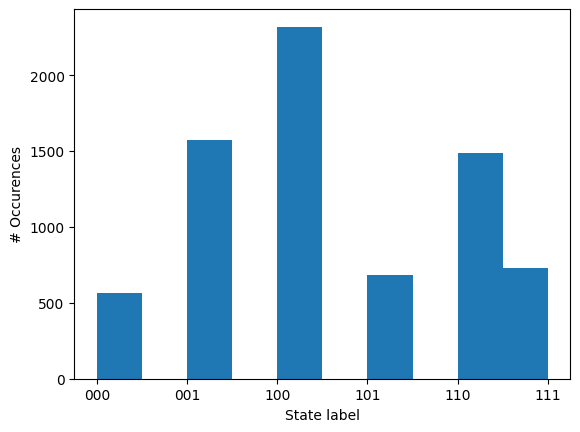

In [29]:
""" State frequency """

plt.hist(new_states)
plt.xticks(np.arange(0, len(unique_states), 1), list(state_label[0:len(unique_states)]))
plt.xlabel('State label')
plt.ylabel('# Occurences')

In [ ]:
dif = np.diff(new_states)
jump = np.where(dif != 0)
jump_dif = np.diff(jump)
median = np.nanmedian(jump_dif)
print(median)

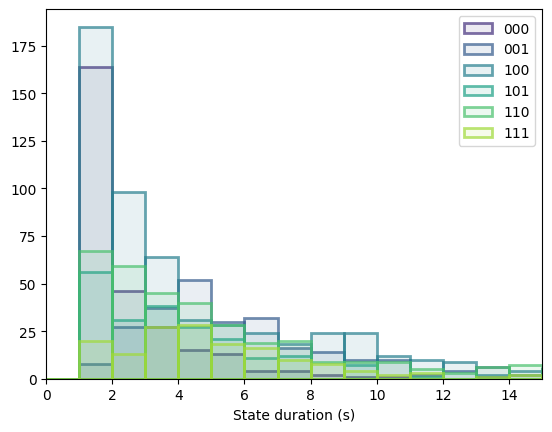

In [81]:
""" State dwell time distribution """

# State for which we have the durations
state_names = new_states[jump][1:]

for s, st in enumerate(unique_states):
    
    state_durations = jump_dif[0][np.where(state_names==st)]
    col = sns.color_palette("viridis", len(unique_states))[int(st)]
    facecolor = mcolors.to_rgba(col,  .10)
    edgecolor = mcolors.to_rgba(col,  .70)
    style = {'facecolor': facecolor, 'edgecolor': edgecolor, 'linewidth': 2}  # 
    label = state_label[int(st)]
    bins = np.arange(0, 20, 1)
    plt.hist(state_durations, bins, label=label, **style)
    # plt.xticks(np.arange(0, np.max(jump_dif[0]), 2), np.arange(0, np.max(jump_dif[0]), 2)/multiplier)
    plt.xlim([0, 15])
    plt.xlabel('State duration (s)')
plt.legend()


3.0


Text(0.5, 0, 'State duration (s)')

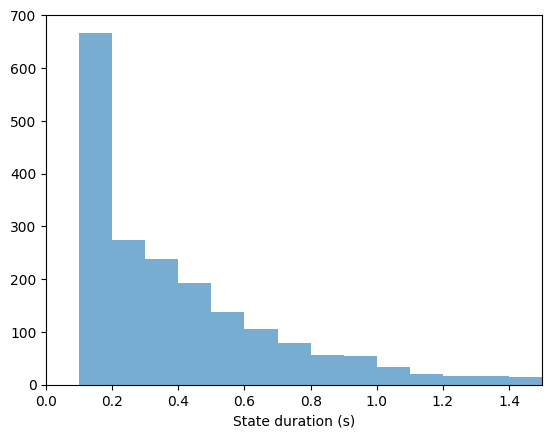

In [82]:
""" State dwell time distribution """

dif = np.diff(new_states)
jump = np.where(dif != 0)
jump_dif = np.diff(jump)
median = np.nanmedian(jump_dif)
print(median)
bins = np.arange(0, 20, 1)
plt.hist(jump_dif[0], bins, alpha=0.6)
plt.xticks(np.arange(0, np.max(jump_dif[0]), 2), np.arange(0, np.max(jump_dif[0]), 2)/multiplier)
plt.xlim([0, 15])
plt.xlabel('State duration (s)')



Text(0, 0.5, 'Previous state')

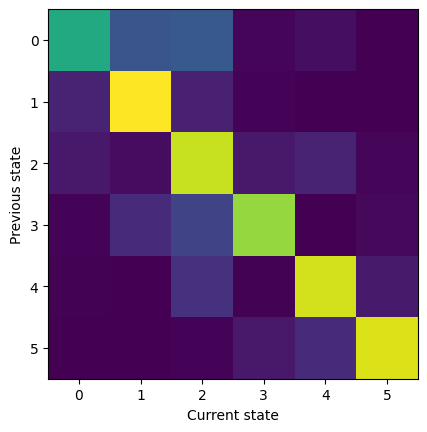

In [190]:
""" State transition matrix (empirical) """
transition_matrix = transition_probabilities(new_states, unique_states)
plt.imshow(transition_matrix)
plt.xlabel('Current state')
plt.ylabel('Previous state')

In [191]:
import plotly.express as px
fig = px.imshow(transition_matrix, text_auto=True)
fig.show()